### 1.EDA for the popular battle royale game PUBG

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy import stats

In [99]:
train = pd.read_csv('./data/train_V2.csv', sep=',', header=0, index_col=0)

In [100]:
for idx,col in enumerate(train.columns):
    print(f"{idx}.{col}: {train[col].dtype}")

0.groupId: object
1.matchId: object
2.assists: int64
3.boosts: int64
4.damageDealt: float64
5.DBNOs: int64
6.headshotKills: int64
7.heals: int64
8.killPlace: int64
9.killPoints: int64
10.kills: int64
11.killStreaks: int64
12.longestKill: float64
13.matchDuration: int64
14.matchType: object
15.maxPlace: int64
16.numGroups: int64
17.rankPoints: int64
18.revives: int64
19.rideDistance: float64
20.roadKills: int64
21.swimDistance: float64
22.teamKills: int64
23.vehicleDestroys: int64
24.walkDistance: float64
25.weaponsAcquired: int64
26.winPoints: int64
27.winPlacePerc: float64


- groupId - 試合内でグループを識別するための整数ID。同じプレイヤーのグループでも、異なる試合では異なる groupId が割り当てられる。

- matchId - 試合を識別するための整数ID。訓練セットとテストセットの間で同じ試合は存在しない。

- assists - このプレイヤーがダメージを与え、味方によってキルされた敵プレイヤーの数。

- boosts - 使用したブーストアイテムの数。

- damageDealt - 与えた合計ダメージ（※ 自傷ダメージは差し引かれる）。

- DBNOs - ノックアウトさせた敵プレイヤーの数（Down But Not Out）。

- headshotKills - ヘッドショットでキルした敵プレイヤーの数。

- heals - 使用した回復アイテムの数。

- killPlace - 敵プレイヤーを倒した数による試合内の順位。 

- killPoints - キル数に基づくプレイヤーの外部ランク（Eloランクのようなもの、キルのみが評価対象）。

- kills - キルした敵プレイヤーの総数。

- killStreaks - 短時間で連続してキルした最大人数。

- longestKill - プレイヤーとキルされた相手の間の、死亡時における最大距離（乗り物で轢いて逃げるなどでも長距離としてカウントされる可能性あり）。

- maxPlace - 試合で記録された最大順位。ただし、グループ数と一致しないこともある（順位情報が欠けていることがあるため）。

- numGroups - 試合におけるグループの総数。

- revives - このプレイヤーが味方を蘇生した回数。

- rideDistance - 乗り物で移動した距離（メートル単位）。

- roadKills - 車両で敵をキルした回数。

- swimDistance - 泳いで移動した距離（メートル単位）。

- teamKills - 味方をキルしてしまった回数。

- vehicleDestroys - 破壊した乗り物の数。

- walkDistance - 歩行による移動距離（メートル単位）。

- weaponsAcquired - 拾った武器の数。

- winPoints - 勝利に基づく外部ランク（Eloランクのようなもので、勝敗のみが評価対象）。

- winPlacePerc - 予測対象の変数。パーセンタイル形式の最終順位で、1が1位、0が最下位を表す。maxPlace に基づいて計算されており、numGroups ではないため、途中の順位が抜けている場合もある。


In [101]:
train.head()

,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
Id,,,,,,,,,,,,,,,,,,,,,
7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,1241,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,0,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,0,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,0,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,0,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


よし、これでデータの概要がつかめてきたので、さっそくデータをさらに深掘りしていきましょう。

In [102]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

In [103]:
train = train.reset_index()

In [104]:
resumetable(train)

Dataset Shape: (4446966, 29)


,Name,dtypes,Missing,Uniques,First Value,Second Value,Third Value,Entropy
0,Id,object,0,4446966,7f96b2f878858a,eef90569b9d03c,1eaf90ac73de72,22.08
1,groupId,object,0,2026745,4d4b580de459be,684d5656442f9e,6a4a42c3245a74,20.68
2,matchId,object,0,47965,a10357fd1a4a91,aeb375fc57110c,110163d8bb94ae,15.53
3,assists,int64,0,20,0,0,1,0.86
4,boosts,int64,0,27,0,0,0,2.05
5,damageDealt,float64,0,29916,0.0,91.47,68.0,9.72
6,DBNOs,int64,0,39,0,0,0,1.60
7,headshotKills,int64,0,34,0,0,0,0.84
8,heals,int64,0,63,0,0,0,2.16
9,killPlace,int64,0,101,60,57,47,6.61


### 2.The killers

キル数をプロットする前に平均と分位数を確認する。

In [105]:
train['kills'] = train['kills'].astype(float)
print("kills Quantiles:")
print(train['kills'].quantile([.01, .025, .1, .25, .5, .75, .9, .975, .99]))
print("kills mean:")
print(train['kills'].mean())

kills Quantiles:
0.010    0.0
0.025    0.0
0.100    0.0
0.250    0.0
0.500    0.0
0.750    1.0
0.900    3.0
0.975    5.0
0.990    7.0
Name: kills, dtype: float64
kills mean:
0.9247833241810259


C:\Users\tatib\AppData\Local\Temp\ipykernel_8820\467276306.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8+' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data['kills'] > data['kills'].quantile(0.99), 'kills'] = '8+'
C:\Users\tatib\AppData\Local\Temp\ipykernel_8820\467276306.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


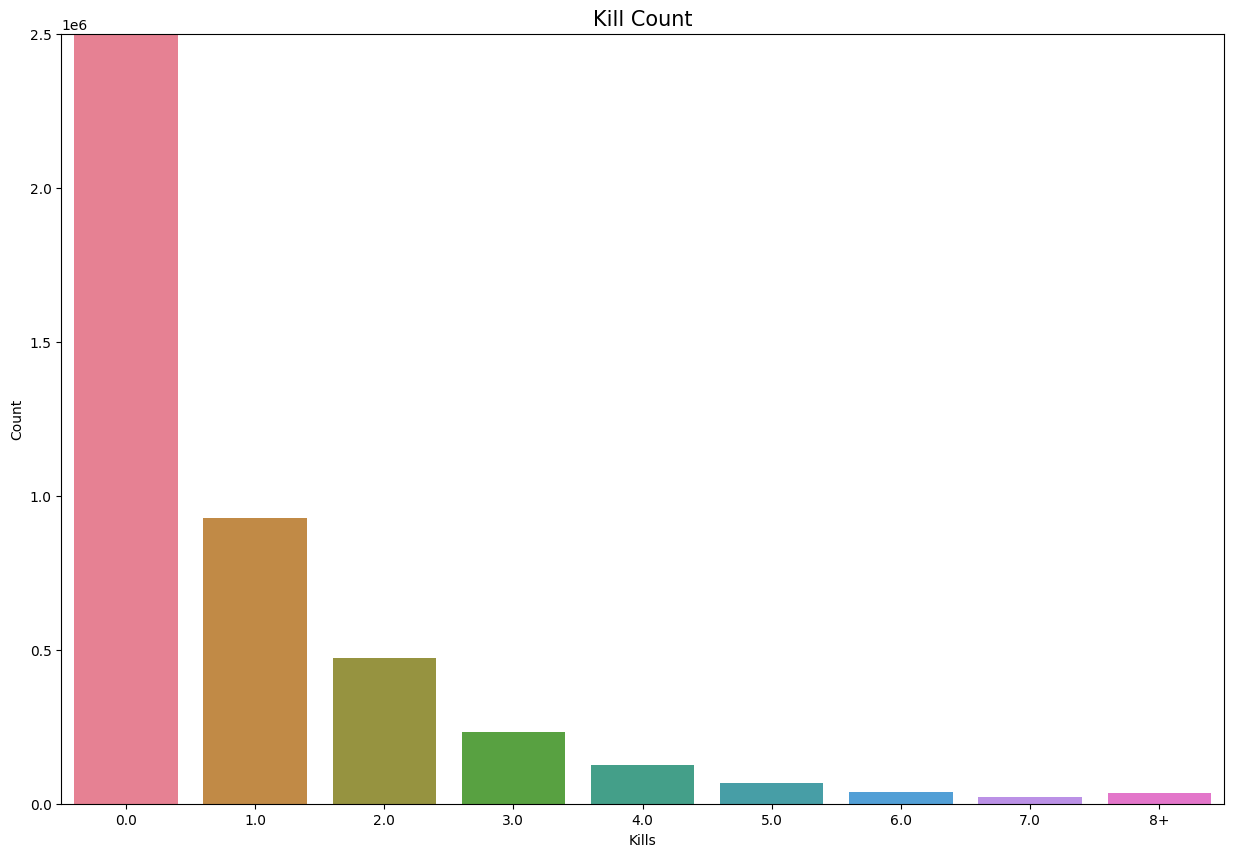

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# データのコピー
data = train.copy()

# killsが99パーセンタイルより大きい値を '8+' に置き換える
data.loc[data['kills'] > data['kills'].quantile(0.99), 'kills'] = '8+'

# カテゴリとして扱うために文字列化
data['kills'] = data['kills'].astype(str)

# killsの値を順番に並べるため、カウントして index をソート
kill_order = data['kills'].value_counts().sort_index().index

# プロット
plt.figure(figsize=(15, 10))
sns.countplot(
    x='kills',
    data=data,
    order=kill_order,
    palette='husl'
)
plt.title("Kill Count", fontsize=15)
plt.xlabel("Kills")
plt.ylabel("Count")

# ← ここで縦軸の範囲を設定
plt.ylim(0, 2500000)

plt.show()


Most people can't make a single kill. At least do they do damage?

C:\Users\tatib\AppData\Local\Temp\ipykernel_8820\2609463613.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['damageDealt'],kde=True)


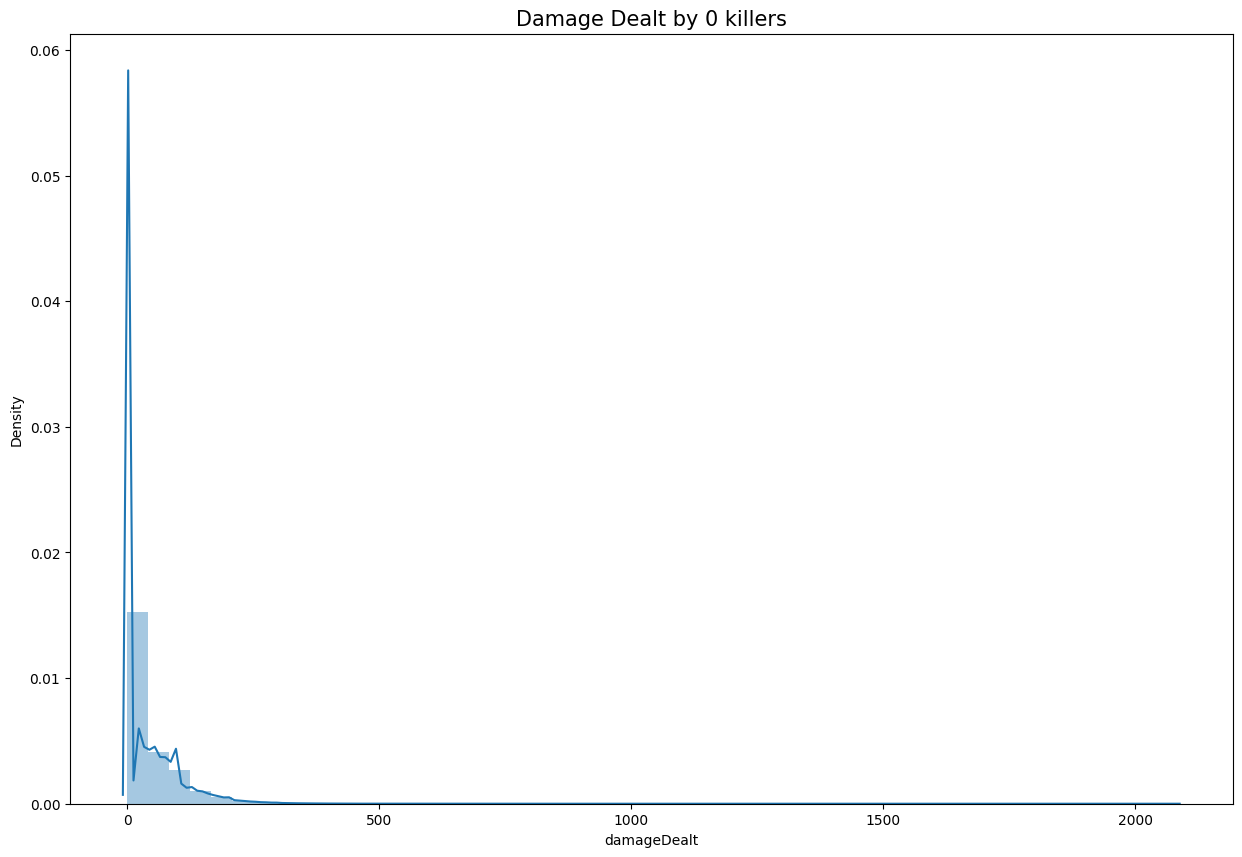

In [107]:
data = train.copy()
data = data[data['kills']==0]
plt.figure(figsize=(15,10))
plt.title("Damage Dealt by 0 killers",fontsize=15)
sns.distplot(data['damageDealt'],kde=True)
plt.show()

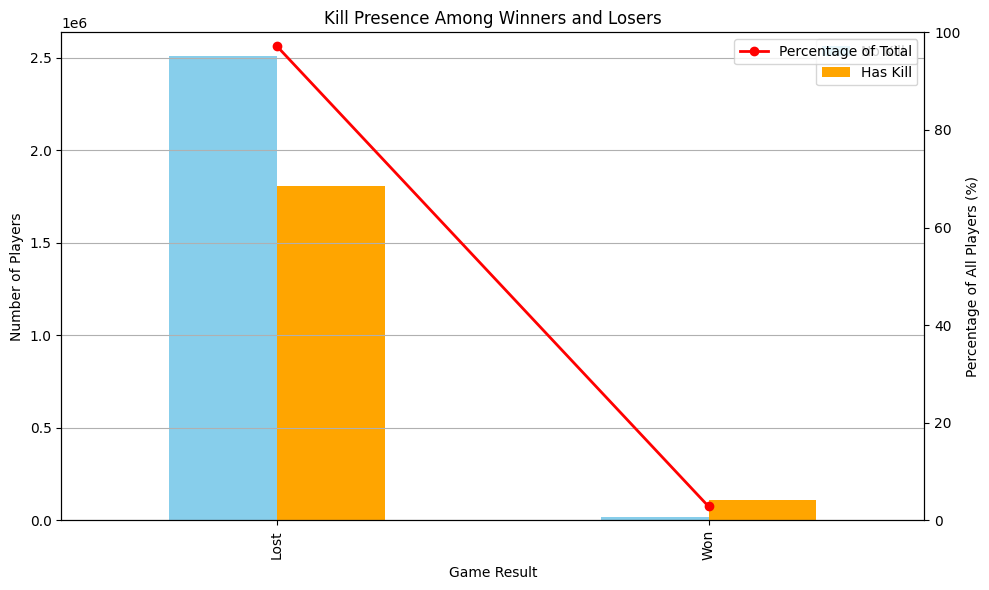

In [108]:
import pandas as pd
import matplotlib.pyplot as plt

# データの準備
data = train.copy()
data['won'] = (data['winPlacePerc'] == 1).astype(int)  # 勝った人: 1, その他: 0
data['has_kill'] = (data['kills'] > 0).astype(int)     # キルあり: 1, キルなし: 0

# クロス集計（人数ベース）
ct = pd.crosstab(data['won'], data['has_kill'])
ct.index = ['Lost', 'Won']
ct.columns = ['No Kill', 'Has Kill']

# 勝者・敗者の全体に占める割合（%）
total_players = len(data)
win_count = (data['won'] == 1).sum()
lose_count = (data['won'] == 0).sum()

# 割合データ
ratios = pd.Series([lose_count / total_players * 100,
                    win_count / total_players * 100],
                   index=['Lost', 'Won'])

# プロット
fig, ax1 = plt.subplots(figsize=(10, 6))

# 棒グラフ（キルの有無ごとの人数）
ct.plot(kind='bar', ax=ax1, color=['skyblue', 'orange'])
ax1.set_ylabel("Number of Players")
ax1.set_xlabel("Game Result")
ax1.set_title("Kill Presence Among Winners and Losers")
ax1.grid(axis='y')

# 折れ線グラフ（全体に占める割合）
ax2 = ax1.twinx()
ax2.plot(ct.index, ratios, marker='o', color='red', linewidth=2, label="Percentage of Total")
ax2.set_ylabel("Percentage of All Players (%)")
ax2.set_ylim(0, 100)

# 凡例とレイアウト調整
ax2.legend(loc='upper right')
plt.tight_layout()
plt.show()


勝利順位（Win Placement Percentage）とキル数の関係をプロットする

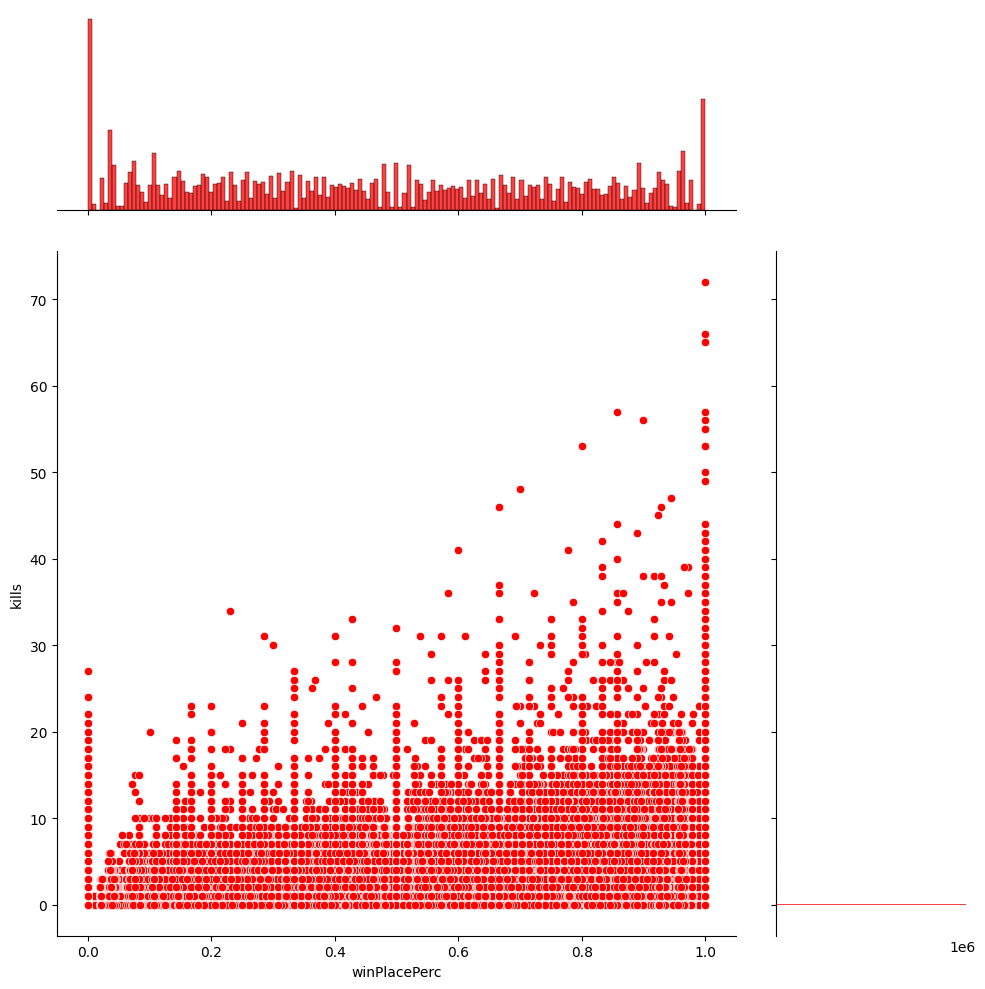

In [109]:
sns.jointplot(x="winPlacePerc", y="kills", data=train, height=10, ratio=3, color="r")
plt.show()

In [110]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

kills = train.copy()

# killsをカテゴリ化
kills['killsCategories'] = pd.cut(
    kills['kills'],
    bins=[-1, 0, 2, 5, 10, 60],
    labels=['0_kills', '1-2_kills', '3-5_kills', '6-10_kills', '10+_kills']
)



C:\Users\tatib\AppData\Local\Temp\ipykernel_8820\2973726124.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


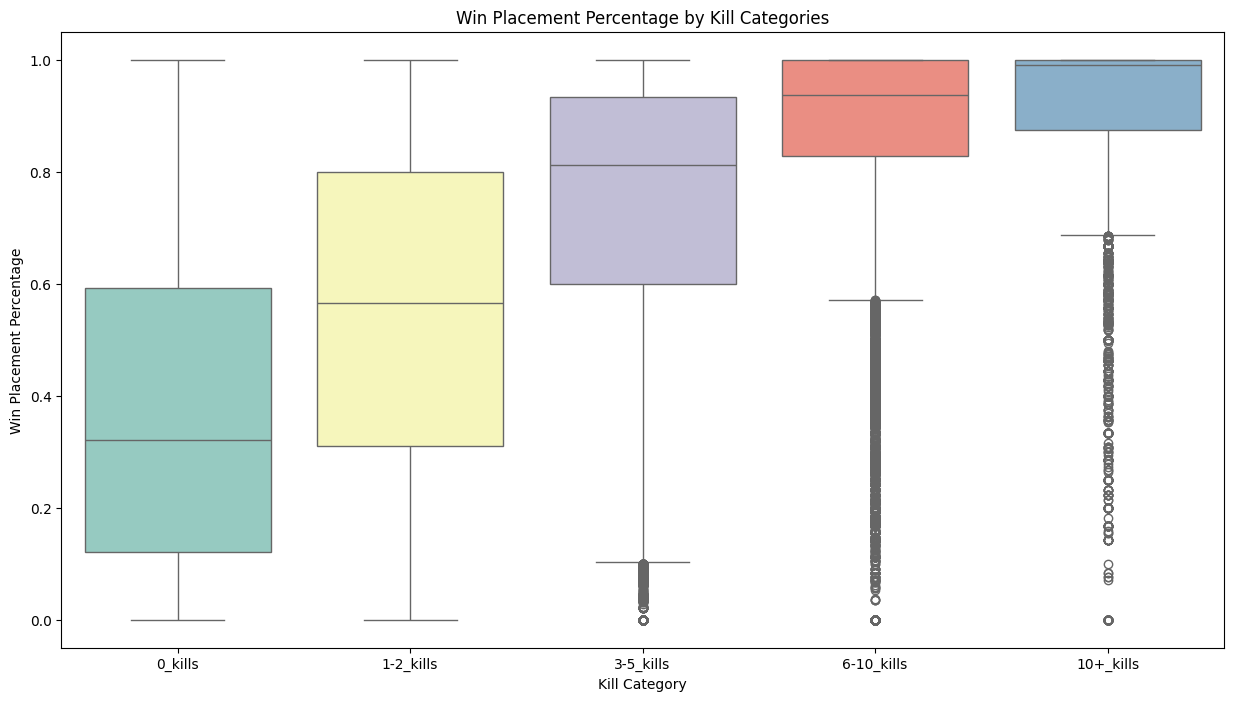

In [111]:
# プロット
plt.figure(figsize=(15, 8))
sns.boxplot(
    x="killsCategories",
    y="winPlacePerc",
    data=kills,
    palette="Set3"  # or "husl", "pastel", "muted", etc.
)
plt.title("Win Placement Percentage by Kill Categories")
plt.xlabel("Kill Category")
plt.ylabel("Win Placement Percentage")
plt.show()

### (3)The Runners

### (4)The Drivers

### (5)The Healers

### (6)Solos,Duos and Squads

### (7)Pearson correlation between variable

In [ ]:
f,ax = plt.subplots(figsize=(15, 15))
sns.heatmap(train.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()


Let's zoom to the top-5 most positive correlated variables with the target.

In [ ]:
k = 5 #number of variables for heatmap
f,ax = plt.subplots(figsize=(11, 11))
cols = train.corr().nlargest(k, 'winPlacePerc')['winPlacePerc'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

目的変数（winPlacePerc）に関しては、いくつかの変数が中程度から高い相関を持っています。最も強い正の相関を示すのは walkDistance であり、最も強い負の相関を示すのは killPlace です。

### (8)Feature Engineering

PUBGの1試合には最大で100人のプレイヤーが参加できますが、実際には「満員」になることはあまりありません。プレイヤーの参加人数を示す変数は存在しないため、自分で作成してみましょう。

In [112]:
train['playersJoined'] = train.groupby('matchId')['matchId'].transform('count')

In [ ]:
data = train.copy()
data = data[data['playersJoined']>49]
plt.figure(figsize=(15,10))
sns.countplot(data['playersJoined'])
plt.title("Players Joined",fontsize=15)
plt.show()

KeyboardInterrupt: 

「playersJoined（参加プレイヤー数）」という特徴量に基づいて、他の多くの特徴量を新たに作成したり、正規化（正則化）したりすることができます。

例えばここでは、「killsNorm（キルの正規化値）」や「damageDealtNorm（与ダメージの正規化値）」という特徴量を作成してみましょう。

ゲームに100人のプレイヤーがいる場合、90人しかいない場合よりも敵を見つけて倒すのが簡単かもしれません。
したがって、キル数を正規化する際には、プレイヤー数100人を基準に、例えば90人の試合での1キルは以下のようにスコア1.1とするという考え方ができます：


これはあくまで仮定にすぎません。他のスケーリング方法を使っても構いません。



In [ ]:
train['killsNorm'] = train['kills']*((100-train['playersJoined'])/100 + 1)
train['damageDealtNorm'] = train['damageDealt']*((100-train['playersJoined'])/100 + 1)
train[['playersJoined', 'kills', 'killsNorm', 'damageDealt', 'damageDealtNorm']][5:8]

もうひとつの簡単な特徴量として、回復（heals）とブースト（boosts）の合計があります。また、移動距離（walkDistance、rideDistance、swimDistance）の合計も有効な特徴量です。

In [ ]:
train['healsAndBoosts'] = train['heals']+train['boosts']
train['totalDistance'] = train['walkDistance']+train['rideDistance']+train['swimDistance']

ブーストアイテムを使うと、移動速度が上がります。また、ゾーン（PUBG用語）の外での生存にも役立ち、結果としてより多くのアイテムを漁る（＝歩行距離が長くなる）ことにもつながります。
したがって、「ブースト数 ÷ 歩行距離」という特徴量を作成してみましょう。

一方、回復アイテム（heals）は移動速度を上げることはありませんが、同じくゾーン外での生存やアイテム回収を助けます。
そこで、同様に「回復数 ÷ 歩行距離」という特徴量も作成しましょう。

In [ ]:
train['boostsPerWalkDistance'] = train['boosts']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where boosts>0 and walkDistance=0. Strange.
train['boostsPerWalkDistance'].fillna(0, inplace=True)
train['healsPerWalkDistance'] = train['heals']/(train['walkDistance']+1) #The +1 is to avoid infinity, because there are entries where heals>0 and walkDistance=0. Strange.
train['healsPerWalkDistance'].fillna(0, inplace=True)
train['healsAndBoostsPerWalkDistance'] = train['healsAndBoosts']/(train['walkDistance']+1) #The +1 is to avoid infinity.
train['healsAndBoostsPerWalkDistance'].fillna(0, inplace=True)
train[['walkDistance', 'boosts', 'boostsPerWalkDistance' ,'heals',  'healsPerWalkDistance', 'healsAndBoosts', 'healsAndBoostsPerWalkDistance']][40:45]

同様に、「killsPerWalkDistance（歩行距離あたりのキル数）」という特徴量も作成しましょう。